# Using Q-learning to solve CartPole problem

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/14R0wNsfdS5_NXUaUOFaSQzajoE9r196n?usp=sharing)

## [The CartPole Problem](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)



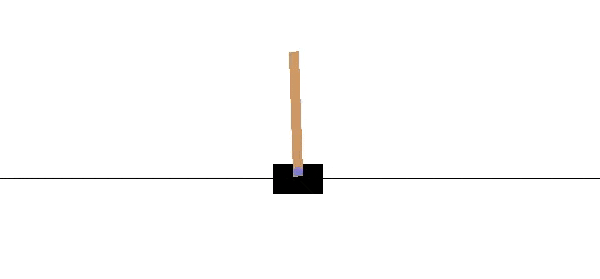

A CartPole-v0 is a simple playground provided by OpenAI to train and test Reinforcement Learning algorithms. The agent is the cart, controlled by two possible actions +1, -1 pointing on moving left or right.

The reward +1 is given at every timestep if the pole remains upright. The goal is to prevent the pole from falling over(maximize total reward) as in GIF above. After 100 consecutive timesteps and an average reward of 195, the problem is considered solved.

The episode ends when the pole is more than 15 degrees from vertical or the cart moves more than 2.4 units from the center.

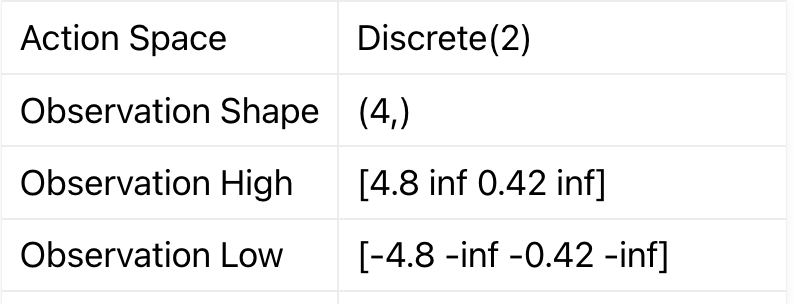

### Action Space

The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

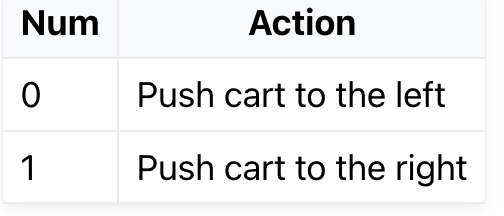

### Observation Space

The observation is a ndarray with shape (4,) with the values corresponding to the following positions and velocities:

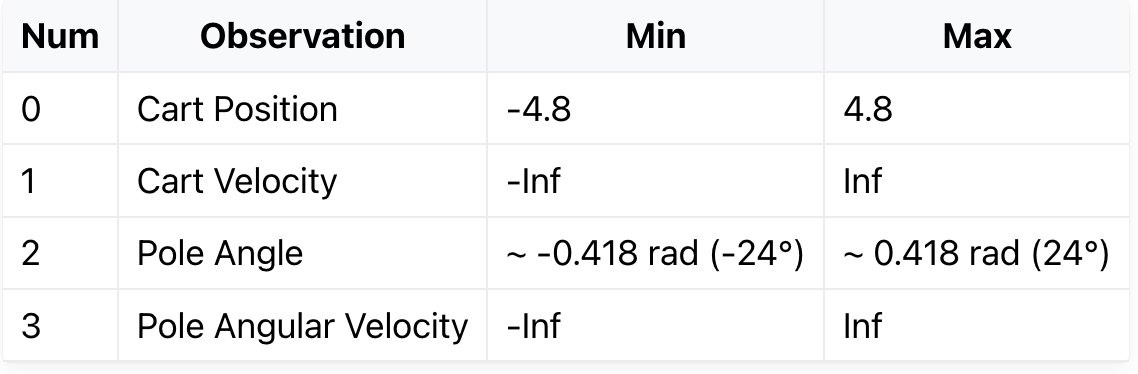

### Rewards 

Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted. The threshold for rewards is 475 for v1.

### Termination

The episode ends if any one of the following occurs:

1.   Termination: Pole Angle is greater than ±12°

2.   Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)

3.   Truncation: Episode length is greater than 500 (200 for v0)


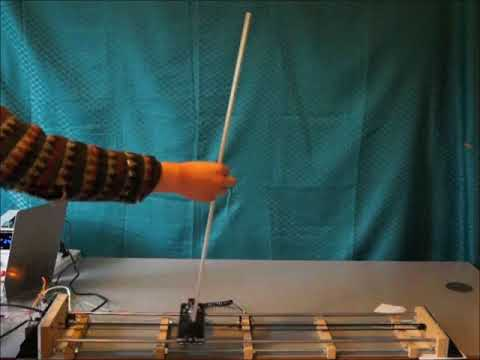

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('5Q14EjnOJZc')

## Data Import

In [2]:
!pip install pygame
import gym
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Intialize Q Learning Hyperparameters


In [3]:
buckets=(3, 3, 6, 6)
num_episodes=200
min_lr=0.1
learning_rate = min_lr
min_epsilon = 0.1
epsilon  = min_epsilon
discount=1.0
decay=25

env = gym.make('CartPole-v0')

# This is the action-value function being initialized to 0's
Q_table = np.zeros(buckets + (env.action_space.n,))

# [position, velocity, angle, angular velocity]
upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50) / 1.]
lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50) / 1.]

#
steps = np.zeros(num_episodes)

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in futu

In [4]:
def discretize_state( obs):
    """
    Takes an observation of the environment and aliases it.
    By doing this, very similar observations can be treated
    as the same and it reduces the state space so that the 
    Q-table can be smaller and more easily filled.
    
    Input:
    obs (tuple): Tuple containing 4 floats describing the current
                    state of the environment.
    
    Output:
    discretized (tuple): Tuple containing 4 non-negative integers smaller 
                            than n where n is the number in the same position
                            in the buckets list.
    """
    discretized = list()
    for i in range(len(obs)):
        scaling = ((obs[i] + abs(lower_bounds[i])) 
                    / (upper_bounds[i] - lower_bounds[i]))
        new_obs = int(round((buckets[i] - 1) * scaling))
        new_obs = min(buckets[i] - 1, max(0, new_obs))
        discretized.append(new_obs)
    return tuple(discretized)

In [5]:
def choose_action(state,epsilon):
        """
        Implementation of e-greedy algorithm. Returns an action (0 or 1).
        
        Input:
        state (tuple): Tuple containing 4 non-negative integers within
                       the range of the buckets.
        
        Output:
        (int) Returns either 0 or 1
        """
        
        if (np.random.random() < epsilon):
            return env.action_space.sample() 
        else:
            return np.argmax(Q_table[state])

In [6]:
def get_action(state, e):
        """
        Another policy based on the Q-table. Slight variation from 
        e-greedy. It assumes the state fed hasn't been discretized and 
        returns a vector with probabilities for each action.
        
        Input: 
        state (tuple): Contains the 4 floats used to describe
                       the current state of the environment.
        e (int): Denotes the episode at which the agent is supposed
                 to be, helping balance exploration and exploitation.
                 
        Output:
        action_vector (numpy array): Vector containing the probability
                                     of each action being chosen at the
                                     current state.
        """
        obs = discretize_state(state)
        action_vector = Q_table[obs]
        epsilon = get_epsilon(e)
        action_vector = normalize(action_vector, epsilon)
        return action_vector

In [7]:
def normalize(action_vector, epsilon):
        """
        Returns a vector with components adding to 1. Ensures 
        
        Input:
        action_vector (numpy array): Contains expected values for each
                                     action at current state from Q-table.
        epsilon (float): Chances that the e-greedy algorithm would 
                         choose an action at random. With this pol
        
        Output:
        new_vector (numpy array): Vector containing the probability
                                  of each action being chosen at the
                                  current state.
        """
        
        total = sum(action_vector)
        new_vector = (1-epsilon)*action_vector/(total)
        new_vector += epsilon/2.0
        return new_vector

In [8]:
def update_q(state, action, reward, new_state,learning_rate):
        """
        Updates Q-table using the rule as described by Sutton and Barto in
        Reinforcement Learning.
        """
        
        Q_table[state][action] += (learning_rate * 
                                        (reward 
                                         + discount * np.max(Q_table[new_state]) 
                                         - Q_table[state][action]))


In [9]:
def get_epsilon(t):
    """Gets value for epsilon. It declines as we advance in episodes."""
    # Ensures that there's almost at least a min_epsilon chance of randomly exploring
    return max(min_epsilon, min(1., 1. - math.log10((t + 1) / decay)))

In [10]:
def get_learning_rate(t):
    """Gets value for learning rate. It declines as we advance in episodes."""
    # Learning rate also declines as we add more episodes
    return max(min_lr, min(1., 1. - math.log10((t + 1) / decay)))

In [11]:
def train():
    """
    Trains agent making it go through the environment and choose actions
    through an e-greedy policy and updating values for its Q-table. The 
    agent is trained by default for 500 episodes with a declining 
    learning rate and epsilon values that with the default values,
    reach the minimum after 198 episodes.
    """
    # Looping for each episode
    for e in range(num_episodes):
        # Initializes the state
        current_state = discretize_state(env.reset())

        learning_rate = get_learning_rate(e)
        epsilon = get_epsilon(e)
        done = False
        
        # Looping for each step
        while not done:
            steps[e] += 1
            # Choose A from S
            epsilon = get_epsilon(e)
            action = choose_action(current_state,epsilon)
            # Take action
            obs, reward, done, _ = env.step(action)
            new_state = discretize_state(obs)
            # Update Q(S,A)
            lr = get_learning_rate(e)
            update_q(current_state, action, reward, new_state,lr)
            current_state = new_state
            
            # We break out of the loop when done is False which is
            # a terminal state.
    print('Finished training!')

In [12]:
def plot_learning():
        
        """
        Plots the number of steps at each episode and prints the
        amount of times that an episode was successfully completed.
        """
        sns.lineplot(range(len(steps)),steps)
        plt.xlabel("Episode")
        plt.ylabel("Steps")
        plt.show()
        t = 0
        for i in range(num_episodes):
            if steps[i] == 200:
                t+=1
        print(t, "episodes were successfully completed.")
        

In [13]:
def run():
        from gym.wrappers.monitoring.video_recorder import VideoRecorder
        before_training = "before_training.mp4"
        video = VideoRecorder(env, before_training)
        """Runs an episode while displaying the cartpole environment."""
        t = 0
        done = False
        current_state = discretize_state(env.reset())
        while not done:
                plt.imshow(env.render(mode='rgb_array'))
                video.capture_frame()
                t = t+1
                action = choose_action(current_state, epsilon)
                obs, reward, done, _ = env.step(action)
                new_state = discretize_state(obs)
                current_state = new_state
        video.close()
        return t   

Finished training!


/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment CartPole-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:102: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  f"{self.__class__} is marked as deprecated and will be removed in the future."
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "
/usr/local/lib/pyt

200

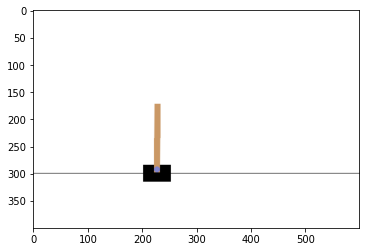

In [14]:
train()
run()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


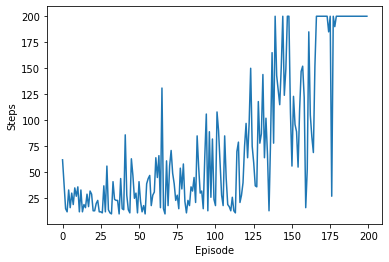

35 episodes were successfully completed.


In [15]:
plot_learning()

In [16]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'
from IPython.display import HTML
html = render_mp4("before_training.mp4")
HTML(html)

## References:

https://github.com/IsaacPatole/CartPole-v0-using-Q-learning-SARSA-and-DNN/blob/master/Qlearning_for_cartpole.py
